In [1]:
%matplotlib ipympl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [4]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
import pickle
import shapely
import pandas as pd
import geopandas as gpd
import xarray as xr
pd.options.display.max_columns = None

import cftime
import datetime

import watershed_workflow 
import watershed_workflow.config
import watershed_workflow.sources
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.land_cover_properties
import watershed_workflow.io

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)

## Input: Parameters and other source data

In [5]:
# Force Watershed Workflow to pull data from this directory rather than a shared data directory.
# This picks up the Coweeta-specific datasets set up here to avoid large file downloads for 
# demonstration purposes.
#
def splitPathFull(path):
    """
    Splits an absolute path into a list of components such that
    os.path.join(*splitPathFull(path)) == path
    """
    parts = []
    while True:
        head, tail = os.path.split(path)
        if head == path:  # root on Unix or drive letter with backslash on Windows (e.g., C:\)
            parts.insert(0, head)
            break
        elif tail == path:  # just a single file or directory
            parts.insert(0, tail)
            break
        else:
            parts.insert(0, tail)
            path = head
    return parts

cwd = splitPathFull(os.getcwd())
assert cwd[-1] == 'workflow'
cwd = cwd[:-1]

# Note, this directory is where downloaded data will be put as well
data_dir = os.path.join(*(cwd + ['input_data',]))
def toInput(filename):
    return os.path.join(data_dir, filename)

output_filenames = dict()
output_dir = os.path.join(*(cwd + ['output_data',]))
def fromOutput(filename):
    return os.path.join(output_dir, filename)    

def toOutput(role, filename):
    output_filenames[role] = filename
    return fromOutput(filename)

# check output and input dirs exist
if not os.path.isdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir, exist_ok=True)
       

In [6]:
# Set the data directory to the local space to get the locally downloaded files
# REMOVE THIS CELL for general use outside fo Coweeta
watershed_workflow.config.setDataDirectory(data_dir)


In [7]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
name = 'RussianRiver'
hucs = ['18010110'] # a list of HUCs to run

# Geometric parameters
# -- parameters to clean and reduce the river network prior to meshing
prune_by_area = 10               # km^2
simplify = 125                   # length scale to target average edge 

# -- mesh triangle refinement control
refine_d0 = 200
refine_d1 = 600

refine_L0 = 125
refine_L1 = 300

refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

# Refine triangles if they get too acute
min_angle = 20 # degrees

# width of reach by stream order (order:width)
river_widths = dict({1:10, 2:10, 3:20, 4:30, 5:30}) 


# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.default_crs


# start and stop time for simulation
# note that this is the overlap of AORC and MODIS
start = cftime.DatetimeGregorian(2007, 8, 1)
end = cftime.DatetimeGregorian(2020, 7, 31)

start_noleap = cftime.DatetimeNoLeap(2007, 8, 1)
end_noleap = cftime.DatetimeNoLeap(2020, 7, 31)
cyclic_nyears = 10


# Global Soil Properties
min_porosity = 0.05 # minimum porosity considered "too small"
max_permeability = 1.e-10 # max value considered "too permeable"
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils


In [8]:
# set up a dictionary of source objects
#
# Data sources, also called managers, deal with downloading and parsing data files from a variety of online APIs.
sources = watershed_workflow.sources.getDefaultSources()

# log the sources that will be used here
watershed_workflow.sources.logSources(sources)


2025-10-06 15:19:33,827 - root - INFO: Using sources:
2025-10-06 15:19:33,828 - root - INFO: --------------
2025-10-06 15:19:33,828 - root - INFO: HUC: WBD
2025-10-06 15:19:33,828 - root - INFO: hydrography: NHDPlus MR v2.1
2025-10-06 15:19:33,828 - root - INFO: DEM: 3DEP 60m
2025-10-06 15:19:33,828 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-10-06 15:19:33,829 - root - INFO: geologic structure: shapefile: "GLHYMPS.shp"
2025-10-06 15:19:33,829 - root - INFO: land cover: NLCD 2021 L48
2025-10-06 15:19:33,829 - root - INFO: LAI: MODIS
2025-10-06 15:19:33,829 - root - INFO: depth to bedrock: raster: "average_soil_and_sedimentary-deposit_thickness.tif"
2025-10-06 15:19:33,829 - root - INFO: meteorology: AORC v1.1


## Reload data

In [9]:
with open(fromOutput('02_watersheds.pickle'), 'rb') as fid:
    watersheds = pickle.load(fid)

In [10]:
with open(fromOutput('04_m2.pickle'), 'rb') as fid:
    m2 = pickle.load(fid)


In [11]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

2D labeled sets
---------------
10000 : CELL : 14831 : "RR-outlet"
10001 : CELL : 14831 : "RR-outlet surface"
10002 : CELL : 13951 : "USGS-11467000"
10003 : CELL : 13951 : "USGS-11467000 surface"
10004 : CELL : 11214 : "USGS-11464000"
10005 : CELL : 11214 : "USGS-11464000 surface"
10006 : CELL : 4658 : "USGS-11463682"
10007 : CELL : 4658 : "USGS-11463682 surface"
10008 : CELL : 10254 : "USGS-11463500"
10009 : CELL : 10254 : "USGS-11463500 surface"
10010 : CELL : 22921 : "USGS-11463000"
10011 : CELL : 22921 : "USGS-11463000 surface"
10012 : CELL : 12109 : "USGS-11462500"
10013 : CELL : 12109 : "USGS-11462500 surface"
10014 : CELL : 16168 : "USGS-11462080"
10015 : CELL : 16168 : "USGS-11462080 surface"
10016 : CELL : 6050 : "USGS-11465350"
10017 : CELL : 6050 : "USGS-11465350 surface"
10018 : CELL : 1683 : "USGS-11465240"
10019 : CELL : 1683 : "USGS-11465240 surface"
10020 : CELL : 18417 : "USGS-11466800"
10021 : CELL : 18417 : "USGS-11466800 surface"
10022 : CELL : 4810 : "USGS-11465200

In [12]:
print(m2.cell_data)

        partition  land_cover
0               0          71
1               0          71
2               0          71
3               0          71
4               0          71
...           ...         ...
244347        575          71
244348        575          42
244349        575          52
244350        575          43
244351        575          42

[244352 rows x 2 columns]


## Subsurface Soil, Geologic Structure

### NRCS Soils

In [13]:
# get NRCS shapes, on a reasonable crs
nrcs = sources['soil structure'].getShapesByGeometry(watersheds.df, out_crs=crs)

nrcs

2025-10-06 15:19:34,413 - root - INFO: Attempting to download source for target '/home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/input_data/soil_structure/SSURGO/SSURGO_-123.3875_38.2993_-122.5296_39.3990.shp'
2025-10-06 15:19:34,590 - root - INFO:   Found 16357 shapes.
2025-10-06 15:19:37,600 - root - INFO: found 788 unique MUKEYs.
2025-10-06 15:19:51,710 - root - INFO: Running Rosetta for van Genutchen parameters
2025-10-06 15:19:51,992 - root - INFO:   ... done
2025-10-06 15:19:51,994 - root - INFO:   requested 753 values
2025-10-06 15:19:51,994 - root - INFO:   got 753 responses
2025-10-06 15:19:52,003 - root - INFO: fixing column: geometry


,mukey,geometry,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [m],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source,ID,name
0,458579,"POLYGON ((-2245879.853 2135312.785, -2245884.7...",0.235542,0.371649,0.000084,1.360609,9.000877e-14,1.5200,7.523577e-13,0.300132,1.557105,40.306579,37.522368,22.171053,NRCS,458579,NRCS-458579
1,458580,"POLYGON ((-2237669.511 2132862.021, -2237948.7...",0.235542,0.371649,0.000084,1.360609,9.000877e-14,1.5200,7.523577e-13,0.226513,1.557105,40.306579,37.522368,22.171053,NRCS,458580,NRCS-458580
2,458590,"POLYGON ((-2237205.912 2134289.718, -2237222.3...",0.262390,0.487592,0.000089,1.293495,1.915196e-13,1.5200,9.100000e-14,0.460526,1.315789,22.100000,27.900000,50.000000,NRCS,458590,NRCS-458590
3,458600,"POLYGON ((-2244143.165 2134892.892, -2244173.6...",NaN,NaN,NaN,NaN,NaN,1.5200,NaN,NaN,NaN,NaN,NaN,NaN,NRCS,458600,NRCS-458600
4,458601,"MULTIPOLYGON (((-2251103.116 2136512.263, -225...",NaN,NaN,NaN,NaN,NaN,1.5200,NaN,NaN,NaN,NaN,NaN,NaN,NRCS,458601,NRCS-458601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,3115322,"MULTIPOLYGON (((-2310357.739 2134103.293, -231...",0.222654,0.379352,0.000107,1.366197,1.430192e-13,1.3715,1.172957e-12,0.214882,1.530043,49.986016,29.407015,20.606969,NRCS,3115322,NRCS-3115322
784,3251971,"MULTIPOLYGON (((-2285692.299 2023919.956, -228...",0.265837,0.429246,0.000085,1.308479,1.034389e-13,1.8826,1.636090e-13,0.439850,1.449514,31.149190,30.074810,38.776000,NRCS,3251971,NRCS-3251971
785,3251972,"MULTIPOLYGON (((-2278859.508 2025515.846, -227...",0.265837,0.429246,0.000085,1.308479,1.034389e-13,1.8826,1.636090e-13,0.439850,1.449514,31.149190,30.074810,38.776000,NRCS,3251972,NRCS-3251972
786,3251973,"MULTIPOLYGON (((-2285034.795 2025528.957, -228...",0.265668,0.433335,0.000086,1.306383,1.088296e-13,1.8573,1.601528e-13,0.443137,1.440768,31.007334,29.405124,39.587543,NRCS,3251973,NRCS-3251973


In [14]:
# create a clean dataframe with just the data we will need for ATS
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(nrcs, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(nrcs, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    nrcs.pop(col)
    
# drop nans
nan_mask = nrcs.isna().any(axis=1)
dropped_mukeys = nrcs.index[nan_mask]

# Drop those rows
nrcs = nrcs[~nan_mask]

assert nrcs['porosity [-]'][:].min() >= min_porosity
assert nrcs['permeability [m^2]'][:].max() <= max_permeability
nrcs

# check for nans
nrcs.isna().any()

mukey                          False
geometry                       False
residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
ID                             False
name                           False
dtype: bool

In [15]:
# Compute the soil color of each cell of the mesh
# Note, we use mukey here because it is an int, while ID is a string
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, nrcs, 'mukey', 
                                                         resolution=50, nodata=-999)

nrcs.set_index('mukey', drop=False, inplace=True)

unique_soil_colors = list(np.unique(soil_color_mukey))
if -999 in unique_soil_colors:
    unique_soil_colors.remove(-999)

# retain only the unique values of soil_color
nrcs = nrcs.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
nrcs['ATS ID'] = range(1000, 1000+len(unique_soil_colors))
nrcs.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(nrcs.index, nrcs.mukey, nrcs['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness


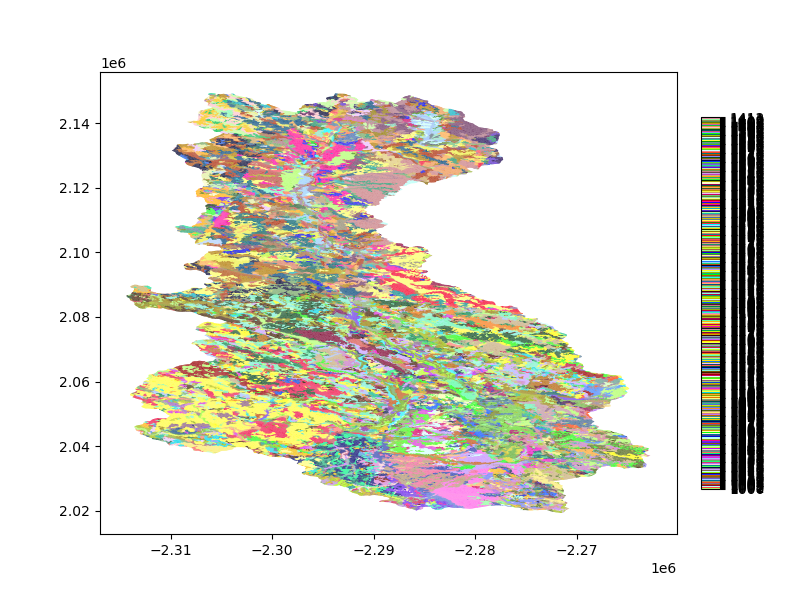

In [16]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(nrcs.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nrcs), 
                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca()) 
plt.show()

### Depth to Bedrock from Pelletier

In [17]:
dtb = sources['depth to bedrock'].getDataset(watersheds.exterior, watersheds.crs)['band_1']


2025-10-06 15:20:00,523 - root - INFO:   from file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/input_data/soil_structure/PelletierDTB/Global_Soil_Regolith_Sediment_1304/data/average_soil_and_sedimentary-deposit_thickness.tif
2025-10-06 15:20:00,551 - root - INFO: Incoming shape area = 0.39872864798547364
2025-10-06 15:20:00,552 - root - INFO: ... buffering incoming shape by = 0.008333333333339965
2025-10-06 15:20:00,555 - root - INFO: ... buffered shape area = 0.4350579206524037


In [18]:
# map to the mesh
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')


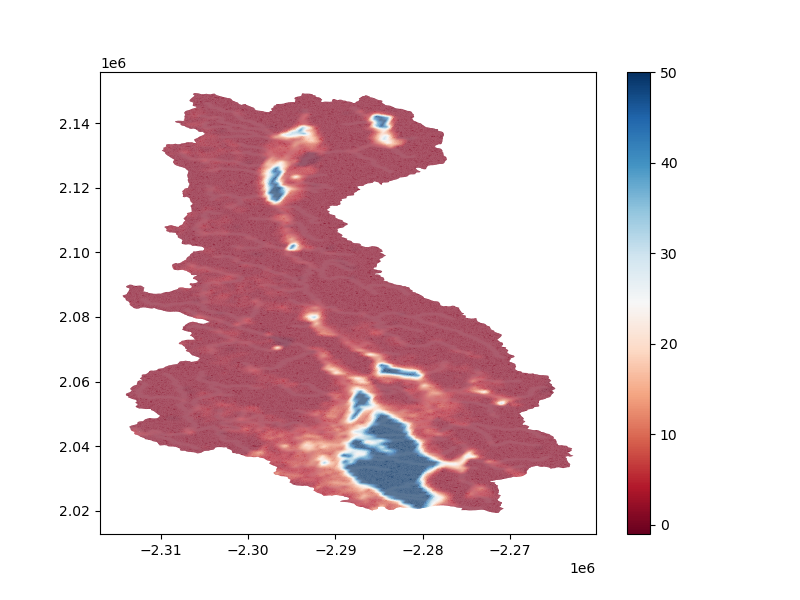

In [19]:
gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

### GLHYMPs Geology

In [20]:
glhymps = sources['geologic structure'].getShapesByGeometry(watersheds.exterior.buffer(1000), watersheds.crs, out_crs=crs)
glhymps = watershed_workflow.soil_properties.mangleGLHYMPSProperties(glhymps,
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

glhymps

2025-10-06 15:20:02,449 - root - INFO:   from file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/input_data/soil_structure/GLHYMPS/GLHYMPS.shp
2025-10-06 15:20:33,430 - root - INFO: fixing column: geometry


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,1791548,GLHYMPS-1791548,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"POLYGON ((-2283053.622 2139060.084, -2283053.6..."
1,656259,GLHYMPS-656259,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"POLYGON ((-2328113.128 2288102.125, -2328132.8..."
2,656628,GLHYMPS-656628,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"POLYGON ((-2222701.266 2190826.581, -2222513.7..."
3,656867,GLHYMPS-656867,GLHYMPS,7.943282e-15,1.50,0.05,0.000174,2.0,0.01,"POLYGON ((-2267927.469 2182457.827, -2265342.6..."
4,656880,GLHYMPS-656880,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"POLYGON ((-2265408.387 2165100.078, -2265293.8..."
...,...,...,...,...,...,...,...,...,...,...
361,660220,GLHYMPS-660220,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"POLYGON ((-2234726.762 2135464.218, -2235492.8..."
362,660222,GLHYMPS-660222,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"MULTIPOLYGON (((-2292304.841 2139820.096, -229..."
363,660223,GLHYMPS-660223,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"POLYGON ((-2285096.096 2144258.138, -2284955.8..."
364,660226,GLHYMPS-660226,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"MULTIPOLYGON (((-2268376.685 2142957.613, -226..."


In [21]:
# does the glhymps dataset cover our domain?  NO!
watershed_all = watersheds.exterior

glhymps['geometry'] = glhymps.intersection(watershed_all.buffer(100))
glhymps = glhymps[~(glhymps.geometry.is_empty | glhymps.geometry.isna())]
glhymps_all = glhymps.union_all()

# does the glhymps dataset cover our domain?  NO!
print(glhymps_all.contains(watershed_all))

# what fraction of the area is not covered?  VERY TINY
missing_part = watershed_all - glhymps_all
print('Area fraction of missing areas:', missing_part.area / watershed_all.area)

# what is it? A bunch of small polygons...
print(type(missing_part))
print(len(missing_part.geoms))
print(set(type(p) for p in missing_part.geoms))

False
Area fraction of missing areas: 7.5383411956851e-05
<class 'shapely.geometry.multipolygon.MultiPolygon'>
8
{<class 'shapely.geometry.polygon.Polygon'>}


In [22]:
print(min(glhymps.area))

4.527437713084432


In [23]:
# ok, can we cover them up by buffering each polygon?  Note this will result in overlapping glhymps polygons, but that's ok in this case.
def buffer_by(df : gpd.GeoDataFrame, dist : float) -> gpd.GeoDataFrame:
    """Buffer each geometry in df, but only including the portion of the buffered shape that is not already in the union of all geometries.
    
    Note this results in overlaps where the buffers are both exterior and overlapping.
    """
    df_all = df.union_all()
    new_geometry = [shapely.union(p, p.buffer(dist) - df_all) for p in df.geometry]
    df_copy = df.copy()
    df_copy['geometry'] = new_geometry
    return df_copy


glhymps = buffer_by(glhymps, 1000)
glhymps_all = glhymps.union_all()
print(glhymps_all.contains(watershed_all))
glhymps


True


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,1791548,GLHYMPS-1791548,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"MULTIPOLYGON (((-2282205.967 2136713.319, -228..."
1,656259,GLHYMPS-656259,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"MULTIPOLYGON (((-2304541.429 2146574.828, -230..."
7,657070,GLHYMPS-657070,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"POLYGON ((-2280210.528 2139776.064, -2280405.7..."
15,657155,GLHYMPS-657155,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"POLYGON ((-2281805.109 2139493.509, -2282235.2..."
32,657225,GLHYMPS-657225,GLHYMPS,1.000000e-13,2.00,0.22,0.000294,2.0,0.01,"MULTIPOLYGON (((-2286477.8 2138922.96, -228647..."
...,...,...,...,...,...,...,...,...,...,...
353,660184,GLHYMPS-660184,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"POLYGON ((-2273663.403 2028624.513, -2273127.6..."
354,660197,GLHYMPS-660197,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"POLYGON ((-2273280.528 2059067.848, -2273099.8..."
356,660202,GLHYMPS-660202,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"MULTIPOLYGON (((-2290832.342 2083524.168, -229..."
362,660222,GLHYMPS-660222,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"MULTIPOLYGON (((-2292008.611 2139057.584, -229..."


In [24]:
# quality check -- make sure glymps shapes cover the watershed
assert glhymps.union_all().contains(watersheds.exterior)
glhymps

,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,1791548,GLHYMPS-1791548,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"MULTIPOLYGON (((-2282205.967 2136713.319, -228..."
1,656259,GLHYMPS-656259,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"MULTIPOLYGON (((-2304541.429 2146574.828, -230..."
7,657070,GLHYMPS-657070,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"POLYGON ((-2280210.528 2139776.064, -2280405.7..."
15,657155,GLHYMPS-657155,GLHYMPS,6.309573e-16,2.50,0.19,0.000025,2.0,0.01,"POLYGON ((-2281805.109 2139493.509, -2282235.2..."
32,657225,GLHYMPS-657225,GLHYMPS,1.000000e-13,2.00,0.22,0.000294,2.0,0.01,"MULTIPOLYGON (((-2286477.8 2138922.96, -228647..."
...,...,...,...,...,...,...,...,...,...,...
353,660184,GLHYMPS-660184,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"POLYGON ((-2273663.403 2028624.513, -2273127.6..."
354,660197,GLHYMPS-660197,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"POLYGON ((-2273280.528 2059067.848, -2273099.8..."
356,660202,GLHYMPS-660202,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"MULTIPOLYGON (((-2290832.342 2083524.168, -229..."
362,660222,GLHYMPS-660222,GLHYMPS,3.019952e-11,1.61,0.05,0.001000,2.0,0.01,"MULTIPOLYGON (((-2292008.611 2139057.584, -229..."


In [25]:
# clean the data
glhymps.pop('logk_stdev [-]')

assert glhymps['porosity [-]'][:].min() >= min_porosity
assert glhymps['permeability [m^2]'][:].max() <= max_permeability
assert glhymps['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

glhymps.isna().any()

ID                             False
name                           False
source                         False
permeability [m^2]             False
porosity [-]                   False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
residual saturation [-]        False
geometry                       False
dtype: bool

In [26]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
def reindex_remove_duplicates(df, index):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(glhymps, 'ID')
glhymps

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,"(1791548,)",GLHYMPS-1791548,GLHYMPS,6.309573e-16,0.19,0.000025,2.0,0.01,"MULTIPOLYGON (((-2282205.967 2136713.319, -228..."
1,"(656259,)",GLHYMPS-656259,GLHYMPS,6.309573e-16,0.19,0.000025,2.0,0.01,"MULTIPOLYGON (((-2304541.429 2146574.828, -230..."
2,"(657070,)",GLHYMPS-657070,GLHYMPS,6.309573e-16,0.19,0.000025,2.0,0.01,"POLYGON ((-2280210.528 2139776.064, -2280405.7..."
3,"(657155,)",GLHYMPS-657155,GLHYMPS,6.309573e-16,0.19,0.000025,2.0,0.01,"POLYGON ((-2281805.109 2139493.509, -2282235.2..."
4,"(657225,)",GLHYMPS-657225,GLHYMPS,1.000000e-13,0.22,0.000294,2.0,0.01,"MULTIPOLYGON (((-2286477.8 2138922.96, -228647..."
...,...,...,...,...,...,...,...,...,...
165,"(660184,)",GLHYMPS-660184,GLHYMPS,3.019952e-11,0.05,0.001000,2.0,0.01,"POLYGON ((-2273663.403 2028624.513, -2273127.6..."
166,"(660197,)",GLHYMPS-660197,GLHYMPS,3.019952e-11,0.05,0.001000,2.0,0.01,"POLYGON ((-2273280.528 2059067.848, -2273099.8..."
167,"(660202,)",GLHYMPS-660202,GLHYMPS,3.019952e-11,0.05,0.001000,2.0,0.01,"MULTIPOLYGON (((-2290832.342 2083524.168, -229..."
168,"(660222,)",GLHYMPS-660222,GLHYMPS,3.019952e-11,0.05,0.001000,2.0,0.01,"MULTIPOLYGON (((-2292008.611 2139057.584, -229..."


In [27]:
assert glhymps.union_all().contains(watersheds.exterior)

In [28]:
# Compute the geo color of each cell of the mesh
geology_color_glhymps = watershed_workflow.getShapePropertiesOnMesh(m2, glhymps, 'index', 
                                                         resolution=50, nodata=-999)

# retain only the unique values of geology that actually appear in our cell mesh
unique_geology_colors = list(np.unique(geology_color_glhymps))
if -999 in unique_geology_colors:
    unique_geology_colors.remove(-999)

# retain only the unique values of geology_color
glhymps = glhymps.loc[unique_geology_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
glhymps['ATS ID'] = range(100, 100+len(unique_geology_colors))
glhymps['TMP_ID'] = glhymps.index
glhymps.reset_index(drop=True, inplace=True)
glhymps.set_index('ATS ID', drop=True, inplace=True)

# create a new geology color using the ATS IDs
geology_color = -np.ones_like(geology_color_glhymps)
for ats_ID, tmp_ID in zip(glhymps.index, glhymps.TMP_ID):
    geology_color[np.where(geology_color_glhymps == tmp_ID)] = ats_ID

glhymps.pop('TMP_ID')

m2.cell_data['geology_color'] = geology_color
                            

In [29]:
geology_color_glhymps.min()

<xarray.DataArray 'index' ()> Size: 8B
array(0)

### Combine to form a complete subsurface dataset

In [30]:
bedrock = watershed_workflow.soil_properties.getDefaultBedrockProperties()

# merge the properties databases
subsurface_props = pd.concat([glhymps, nrcs, bedrock])

# save the properties to disk for use in generating input file
subsurface_props.to_csv(toOutput('subsurface_properties', f'{name}_subsurface_properties.csv'))
subsurface_props


,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1791548,)",GLHYMPS-1791548,GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,"MULTIPOLYGON (((-2282205.967 2136713.319, -228...",NaN,NaN
101,"(656259,)",GLHYMPS-656259,GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,"MULTIPOLYGON (((-2304541.429 2146574.828, -230...",NaN,NaN
102,"(657070,)",GLHYMPS-657070,GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,"POLYGON ((-2280210.528 2139776.064, -2280405.7...",NaN,NaN
103,"(657155,)",GLHYMPS-657155,GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,"POLYGON ((-2281805.109 2139493.509, -2282235.2...",NaN,NaN
104,"(657225,)",GLHYMPS-657225,GLHYMPS,1.000000e-13,0.220000,0.000294,2.000000,0.010000,"MULTIPOLYGON (((-2286477.8 2138922.96, -228647...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1409,3115322,NRCS-3115322,NRCS,1.172957e-12,0.214882,0.000107,1.366197,0.222654,"MULTIPOLYGON (((-2310357.739 2134103.293, -231...",3115322.0,1.3715
1410,3251971,NRCS-3251971,NRCS,1.636090e-13,0.439850,0.000085,1.308479,0.265837,"MULTIPOLYGON (((-2285692.299 2023919.956, -228...",3251971.0,1.8826
1411,3251972,NRCS-3251972,NRCS,1.636090e-13,0.439850,0.000085,1.308479,0.265837,"MULTIPOLYGON (((-2278859.508 2025515.846, -227...",3251972.0,1.8826
1412,3251973,NRCS-3251973,NRCS,1.601528e-13,0.443137,0.000086,1.306383,0.265668,"MULTIPOLYGON (((-2285034.795 2025528.957, -228...",3251973.0,1.8573


## Extrude the 2D Mesh to make a 3D mesh

In [31]:
# set the floor of the domain as max DTB
dtb_max = np.nanmax(m2.cell_data['dtb'].values)
m2.cell_data['dtb'] = m2.cell_data['dtb'].fillna(dtb_max)

print(f'total thickness: {dtb_max} m')
total_thickness = 50.


total thickness: 50.0 m


In [32]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimizeDzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.05447108 0.07161305 0.11027281 0.17443206 0.26441087 0.36782677
 0.45697337 0.49999999]
2.0000000000000004


In [33]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [34]:
# 50m total thickness, minus 2m soil thickness, leaves us with 48 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimizeDzs(1, 10, 48, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 2.0, 4.0, 8.0, 11, 11, 11]
print(dzs_geo)
print(sum(dzs_geo))

[2.71113048 5.85796948 9.43304714 9.99786869 9.99998875 9.99999546]
48.0
[1.0, 2.0, 4.0, 8.0, 11, 11, 11]
48.0


In [35]:
print(np.unique(m2.cell_data['soil_color'].to_numpy()))

[  -1 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012
 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026
 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040
 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054
 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068
 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082
 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096
 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110
 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124
 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138
 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152
 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180
 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194
 1195 

In [36]:
# layer extrusion
DTB = m2.cell_data['dtb'].values
soil_color = m2.cell_data['soil_color'].values
geo_color = m2.cell_data['geology_color'].values
assert min(geo_color) > 0
soil_thickness = m2.cell_data['soil thickness'].values


# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # use glhymps params
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                                 soil_color,
                                 br_or_geo)

    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    geo_or_br = np.where(depth < DTB, geo_color, 999)

    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
print('using the following mat ids:', layer_mat_id_used)
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
subsurface_props_used


2025-10-06 15:20:35,758 - root - INFO: Cell summary:
2025-10-06 15:20:35,758 - root - INFO: ------------------------------------------------------------
2025-10-06 15:20:35,759 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-10-06 15:20:35,759 - root - INFO: ------------------------------------------------------------
2025-10-06 15:20:35,759 - root - INFO:  00 	| 00 	| 1115 	|   0.050000 	|   0.000000
2025-10-06 15:20:35,759 - root - INFO:  01 	| 01 	| 1115 	|   0.050000 	|   0.050000
2025-10-06 15:20:35,759 - root - INFO:  02 	| 02 	| 1115 	|   0.050000 	|   0.100000
2025-10-06 15:20:35,759 - root - INFO:  03 	| 03 	| 1115 	|   0.120000 	|   0.150000
2025-10-06 15:20:35,759 - root - INFO:  04 	| 04 	| 1115 	|   0.230000 	|   0.270000
2025-10-06 15:20:35,760 - root - INFO:  05 	| 05 	| 1115 	|   0.500000 	|   0.500000
2025-10-06 15:20:35,760 - root - INFO:  06 	| 06 	| 1115 	|   0.500000 	|   1.000000
2025-10-06 15:20:35,760 - root - INFO:  07 	| 07 	|  999 	|   0.500000 	|   1.5

using the following mat ids: [np.int64(100), np.int64(101), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(108), np.int64(109), np.int64(110), np.int64(111), np.int64(112), np.int64(113), np.int64(114), np.int64(117), np.int64(118), np.int64(119), np.int64(120), np.int64(121), np.int64(123), np.int64(124), np.int64(125), np.int64(126), np.int64(127), np.int64(128), np.int64(129), np.int64(130), np.int64(131), np.int64(132), np.int64(133), np.int64(134), np.int64(135), np.int64(136), np.int64(137), np.int64(138), np.int64(139), np.int64(140), np.int64(141), np.int64(142), np.int64(143), np.int64(144), np.int64(145), np.int64(147), np.int64(148), np.int64(150), np.int64(151), np.int64(152), np.int64(153), np.int64(154), np.int64(155), np.int64(156), np.int64(157), np.int64(158), np.int64(159), np.int64(160), np.int64(161), np.int64(162), np.int64(163), np.int64(164), np.int64(165), np.int64(166), np.int64(168), np.int64(169), np.int64(170), np.int64(171), np.int64(1

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1791548,)",GLHYMPS-1791548,GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,"MULTIPOLYGON (((-2282205.967 2136713.319, -228...",NaN,NaN
101,"(656259,)",GLHYMPS-656259,GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,"MULTIPOLYGON (((-2304541.429 2146574.828, -230...",NaN,NaN
103,"(657155,)",GLHYMPS-657155,GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,"POLYGON ((-2281805.109 2139493.509, -2282235.2...",NaN,NaN
104,"(657225,)",GLHYMPS-657225,GLHYMPS,1.000000e-13,0.220000,0.000294,2.000000,0.010000,"MULTIPOLYGON (((-2286477.8 2138922.96, -228647...",NaN,NaN
105,"(657247,)",GLHYMPS-657247,GLHYMPS,1.000000e-13,0.220000,0.000294,2.000000,0.010000,"MULTIPOLYGON (((-2296081.47 2137750.057, -2296...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1408,3115319,NRCS-3115319,NRCS,8.530679e-13,0.340084,0.000100,1.400788,0.207362,"MULTIPOLYGON (((-2317263.327 2092725.379, -231...",3115319.0,0.512577
1409,3115322,NRCS-3115322,NRCS,1.172957e-12,0.214882,0.000107,1.366197,0.222654,"MULTIPOLYGON (((-2310357.739 2134103.293, -231...",3115322.0,1.371500
1410,3251971,NRCS-3251971,NRCS,1.636090e-13,0.439850,0.000085,1.308479,0.265837,"MULTIPOLYGON (((-2285692.299 2023919.956, -228...",3251971.0,1.882600
1411,3251972,NRCS-3251972,NRCS,1.636090e-13,0.439850,0.000085,1.308479,0.265837,"MULTIPOLYGON (((-2278859.508 2025515.846, -227...",3251972.0,1.882600


In [37]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [38]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    

2D labeled sets
---------------
10000 : CELL : 14831 : "RR-outlet"
10001 : CELL : 14831 : "RR-outlet surface"
10002 : CELL : 13951 : "USGS-11467000"
10003 : CELL : 13951 : "USGS-11467000 surface"
10004 : CELL : 11214 : "USGS-11464000"
10005 : CELL : 11214 : "USGS-11464000 surface"
10006 : CELL : 4658 : "USGS-11463682"
10007 : CELL : 4658 : "USGS-11463682 surface"
10008 : CELL : 10254 : "USGS-11463500"
10009 : CELL : 10254 : "USGS-11463500 surface"
10010 : CELL : 22921 : "USGS-11463000"
10011 : CELL : 22921 : "USGS-11463000 surface"
10012 : CELL : 12109 : "USGS-11462500"
10013 : CELL : 12109 : "USGS-11462500 surface"
10014 : CELL : 16168 : "USGS-11462080"
10015 : CELL : 16168 : "USGS-11462080 surface"
10016 : CELL : 6050 : "USGS-11465350"
10017 : CELL : 6050 : "USGS-11465350 surface"
10018 : CELL : 1683 : "USGS-11465240"
10019 : CELL : 1683 : "USGS-11465240 surface"
10020 : CELL : 18417 : "USGS-11466800"
10021 : CELL : 18417 : "USGS-11466800 surface"
10022 : CELL : 4810 : "USGS-11465200

In [39]:
# save the mesh to disk
output_filenames['mesh'] = toOutput('final mesh', f'{name}.exo')
try:
    os.remove(output_filenames['mesh'])
except FileNotFoundError:
    pass
m3.writeExodus(output_filenames['mesh'])


You are using exodus.py v 1.21.6 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013-2023 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/output_data/RussianRiver.exo


2025-10-06 15:21:51,894 - root - INFO: writing partition data as variable
2025-10-06 15:21:52,262 - root - INFO: adding side set: 1
2025-10-06 15:21:53,133 - root - INFO: adding side set: 2
2025-10-06 15:21:53,395 - root - INFO: adding side set: 3
2025-10-06 15:21:53,515 - root - INFO: adding side set: 10001
2025-10-06 15:21:53,618 - root - INFO: adding side set: 10003
2025-10-06 15:21:53,721 - root - INFO: adding side set: 10005
2025-10-06 15:21:53,822 - root - INFO: adding side set: 10007
2025-10-06 15:21:53,918 - root - INFO: adding side set: 10009
2025-10-06 15:21:54,045 - root - INFO: adding side set: 10011
2025-10-06 15:21:54,156 - root - INFO: adding side set: 10013
2025-10-06 15:21:54,261 - root - INFO: adding side set: 10015
2025-10-06 15:21:54,366 - root - INFO: adding side set: 10017
2025-10-06 15:21:54,467 - root - INFO: adding side set: 10019
2025-10-06 15:21:54,557 - root - INFO: adding side set: 10021
2025-10-06 15:21:54,658 - root - INFO: adding side set: 10023
2025-10-

Closing exodus file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/output_data/RussianRiver.exo


In [42]:
# save labeled set info to disk as well -- just enough for use in input file (we don't need ids)
labeled_sets = [(ls.name, ls.setid, ls.entity) for ls in m3.labeled_sets] + \
               [(ls.name, ls.setid, 'FACE') for ls in m3.side_sets]

with open(toOutput('labeled set metadata', 'ls_metadata.pickle'), 'wb') as fid:
    pickle.dump(labeled_sets, fid)